In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [29]:
# Dataset preparation
class TranslationDataset(Dataset):
    def __init__(self, source_sentences, target_sentences):
        self.source_sentences = source_sentences
        self.target_sentences = target_sentences

    def __len__(self):
        return len(self.source_sentences)

    def __getitem__(self, idx):
        return self.source_sentences[idx], self.target_sentences[idx]

In [30]:
# Add a tokenizer and padding function
def tokenize_and_pad(sentences, vocab, max_len):
    tokenized = [[vocab.get(token, vocab["<unk>"]) for token in sentence.split()] for sentence in sentences]
    padded = [tokens + [vocab["<pad>"]] * (max_len - len(tokens)) if len(tokens) < max_len else tokens[:max_len] for tokens in tokenized]
    return torch.tensor(padded, dtype=torch.long)

def build_vocab(sentences, special_tokens=["<pad>", "<unk>", "<sos>", "<eos>"]):
    vocab = {token: idx for idx, token in enumerate(special_tokens)}
    idx = len(vocab)
    for sentence in sentences:
        for token in sentence.split():
            if token not in vocab:
                vocab[token] = idx
                idx += 1
    return vocab

In [31]:
# Update the load_and_prepare_data function to preprocess data
def load_and_prepare_data():
    # Load data from .dev and .devtest files
    with open("urd_Arab.dev", "r", encoding="utf-8") as f:
        urdu_dev = f.readlines()
    with open("urd_Arab.devtest", "r", encoding="utf-8") as f:
        urdu_devtest = f.readlines()
    with open("eng_Latn.dev", "r", encoding="utf-8") as f:
        eng_dev = f.readlines()
    with open("eng_Latn.devtest", "r", encoding="utf-8") as f:
        eng_devtest = f.readlines()

    # Combine and shuffle
    urdu_sentences = urdu_dev + urdu_devtest
    eng_sentences = eng_dev + eng_devtest
    combined_data = list(zip(urdu_sentences, eng_sentences))
    random.shuffle(combined_data)

    # Split into source (Urdu) and target (English)
    source_sentences, target_sentences = zip(*combined_data)

    # Split into train, validation, and test sets
    train_src, temp_src, train_tgt, temp_tgt = train_test_split(
        source_sentences, target_sentences, test_size=0.3, random_state=42
    )
    val_src, test_src, val_tgt, test_tgt = train_test_split(
        temp_src, temp_tgt, test_size=0.5, random_state=42
    )

    # Build vocabularies for source (Urdu) and target (English)
    urdu_vocab = build_vocab(source_sentences)
    eng_vocab = build_vocab(target_sentences)

    # Add <sos> and <eos> tokens to target sentences
    train_tgt = [f"<sos> {sentence.strip()} <eos>" for sentence in train_tgt]
    val_tgt = [f"<sos> {sentence.strip()} <eos>" for sentence in val_tgt]
    test_tgt = [f"<sos> {sentence.strip()} <eos>" for sentence in test_tgt]

    # Tokenize and pad sentences
    max_len_src = 50  # Adjust as needed
    max_len_tgt = 50  # Adjust as needed
    train_src = tokenize_and_pad(train_src, urdu_vocab, max_len_src)
    train_tgt = tokenize_and_pad(train_tgt, eng_vocab, max_len_tgt)
    val_src = tokenize_and_pad(val_src, urdu_vocab, max_len_src)
    val_tgt = tokenize_and_pad(val_tgt, eng_vocab, max_len_tgt)
    test_src = tokenize_and_pad(test_src, urdu_vocab, max_len_src)
    test_tgt = tokenize_and_pad(test_tgt, eng_vocab, max_len_tgt)

    return train_src, train_tgt, val_src, val_tgt, test_src, test_tgt, urdu_vocab, eng_vocab

In [32]:
# Model definition
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.hidden_dim = hidden_dim

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.rnn(embedded)
        return outputs, hidden, cell

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Parameter(torch.rand(hidden_dim))

    def forward(self, hidden, encoder_outputs):
        # Ensure hidden has the correct shape (batch_size, hidden_dim)
        if hidden.dim() == 3:  # If hidden is (1, batch_size, hidden_dim), remove the first dimension
            hidden = hidden.squeeze(0)

        # Calculate attention weights
        seq_len = encoder_outputs.shape[1]
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)  # (batch_size, seq_len, hidden_dim)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # (batch_size, seq_len, hidden_dim)
        attention = torch.sum(self.v * energy, dim=2)  # (batch_size, seq_len)
        return torch.softmax(attention, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(hidden_dim + emb_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)
        self.attention = Attention(hidden_dim)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        attn_weights = self.attention(hidden, encoder_outputs)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        rnn_input = torch.cat((embedded, attn_applied), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        prediction = self.fc_out(torch.cat((output.squeeze(1), attn_applied.squeeze(1)), dim=1))
        return prediction, hidden, cell

In [33]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len = trg.shape[1]
        batch_size = trg.shape[0]
        trg_vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        encoder_outputs, hidden, cell = self.encoder(src)
        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:, t, :] = output
            top1 = output.argmax(1)
            input = trg[:, t] if random.random() < teacher_forcing_ratio else top1

        return outputs

In [34]:
# Training and evaluation
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=10):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for src, trg in train_loader:
            src, trg = src.to(device), trg.to(device)
            optimizer.zero_grad()
            output = model(src, trg)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for src, trg in val_loader:
                src, trg = src.to(device), trg.to(device)
                output = model(src, trg, 0)
                output_dim = output.shape[-1]
                output = output[:, 1:].reshape(-1, output_dim)
                trg = trg[:, 1:].reshape(-1)
                loss = criterion(output, trg)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

In [35]:
# Plotting results
def plot_results(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [36]:
# Update evaluate_bleu_score to filter padding tokens and debug vocabulary mapping
def evaluate_bleu_score(model, test_loader, device, eng_vocab):
    # Generate translations for the test set
    predictions, references = [], []
    model.eval()
    with torch.no_grad():
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)  # Ensure src and trg are on the same device
            output = model(src, trg, 0)  # No teacher forcing
            output = output.argmax(2)  # Get predicted tokens
            predictions.extend(output.cpu().numpy())  # Move to CPU for saving
            references.extend(trg.cpu().numpy())  # Move to CPU for saving

    # Convert predictions and references to text (filter <pad>)
    idx_to_token = {idx: token for token, idx in eng_vocab.items()}
    predictions_text = [
        " ".join([idx_to_token[idx] for idx in pred if idx_to_token[idx] not in ["<pad>", "<sos>", "<eos>"]])
        for pred in predictions
    ]
    references_text = [
        " ".join([idx_to_token[idx] for idx in ref if idx_to_token[idx] not in ["<pad>", "<sos>", "<eos>"]])
        for ref in references
    ]

    # Save predictions and references to files
    with open("predictions.txt", "w", encoding="utf-8") as pred_file, \
         open("references.txt", "w", encoding="utf-8") as ref_file:
        for pred, ref in zip(predictions_text, references_text):
            pred_file.write(pred + "\n")
            ref_file.write(ref + "\n")

    # Debug: Print a few predictions and references
    print("Sample Predictions and References:")
    for i in range(5):  # Print first 5 examples
        print("Prediction:", predictions_text[i])
        print("Reference:", references_text[i])

    # Use multi-bleu.perl to calculate BLEU score
    import subprocess
    bleu_score = subprocess.run(
        ["perl", "multi-bleu.perl", "references.txt"],
        input=open("predictions.txt", "r").read(),
        text=True,
        capture_output=True
    )
    print("BLEU Score:", bleu_score.stdout)

In [37]:
def beam_search_decode(model, src_tensor, urdu_vocab, eng_vocab, device, max_len=50, beam_width=3):
    model.eval()
    idx_to_token = {idx: token for token, idx in eng_vocab.items()}
    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src_tensor)
        sequences = [[[eng_vocab["<sos>"]], 0.0]]  # Start with <sos> token as a list and score 0.0

        for _ in range(max_len):
            all_candidates = []
            for seq, score in sequences:
                trg_tensor = torch.tensor([seq[-1]], dtype=torch.long).to(device)  # Use the last token in the sequence
                output, hidden, cell = model.decoder(trg_tensor, hidden, cell, encoder_outputs)
                topk = torch.topk(output, beam_width, dim=1)  # Get top-k predictions
                for i in range(beam_width):
                    candidate = seq + [topk.indices[0][i].item()]  # Append the new token to the sequence
                    candidate_score = score - torch.log(topk.values[0][i]).item()  # Add log-probability
                    all_candidates.append((candidate, candidate_score))

            # Select top-k sequences
            sequences = sorted(all_candidates, key=lambda x: x[1])[:beam_width]

            # Stop if all sequences end with <eos>
            if all(seq[-1] == eng_vocab["<eos>"] for seq, _ in sequences):
                break

        # Return the best sequence (excluding <sos> and <eos>)
        best_seq = sequences[0][0]
        translated_sentence = " ".join([idx_to_token[idx] for idx in best_seq[1:-1]])
        return translated_sentence

In [38]:
def translate_sentence(sentence, model, urdu_vocab, eng_vocab, device, max_len=50):
    tokens = [urdu_vocab.get(token, urdu_vocab["<unk>"]) for token in sentence.split()]
    tokens = tokens[:max_len]  # Truncate if longer than max_len
    tokens = tokens + [urdu_vocab["<pad>"]] * (max_len - len(tokens))  # Pad if shorter
    src_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension

    # Use beam search decoding
    return beam_search_decode(model, src_tensor, urdu_vocab, eng_vocab, device, max_len)

In [39]:
train_src, train_tgt, val_src, val_tgt, test_src, test_tgt, urdu_vocab, eng_vocab = load_and_prepare_data()

In [40]:
# Update INPUT_DIM and OUTPUT_DIM based on vocab sizes
INPUT_DIM = len(urdu_vocab)
OUTPUT_DIM = len(eng_vocab)
# Define hyperparameters
EMB_DIM = 512  # Increased embedding dimension
HIDDEN_DIM = 1024  # Increased hidden dimension
BATCH_SIZE = 32
EPOCHS = 20  # epochs for training
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
# Move datasets to the correct device
train_src, train_tgt = train_src.to(DEVICE), train_tgt.to(DEVICE)
val_src, val_tgt = val_src.to(DEVICE), val_tgt.to(DEVICE)
test_src, test_tgt = test_src.to(DEVICE), test_tgt.to(DEVICE)

In [42]:
# Create datasets and dataloaders
train_dataset = TranslationDataset(train_src, train_tgt)
val_dataset = TranslationDataset(val_src, val_tgt)
test_dataset = TranslationDataset(test_src, test_tgt)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [43]:
# Initialize model, optimizer, and loss function
encoder = Encoder(INPUT_DIM, EMB_DIM, HIDDEN_DIM)
decoder = Decoder(OUTPUT_DIM, EMB_DIM, HIDDEN_DIM)
model = Seq2Seq(encoder, decoder, DEVICE).to(DEVICE)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [44]:
# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, criterion, DEVICE, EPOCHS)

Epoch 1, Train Loss: 7.8599, Val Loss: 7.7435
Epoch 2, Train Loss: 7.0082, Val Loss: 8.0348
Epoch 3, Train Loss: 6.5884, Val Loss: 8.2219
Epoch 4, Train Loss: 5.9456, Val Loss: 8.4480
Epoch 5, Train Loss: 5.1814, Val Loss: 8.7294
Epoch 6, Train Loss: 4.2468, Val Loss: 8.9525
Epoch 7, Train Loss: 3.6056, Val Loss: 9.1630
Epoch 8, Train Loss: 3.0433, Val Loss: 9.4528
Epoch 9, Train Loss: 2.6283, Val Loss: 9.5557
Epoch 10, Train Loss: 2.2081, Val Loss: 9.6552
Epoch 11, Train Loss: 1.8649, Val Loss: 9.7767
Epoch 12, Train Loss: 1.3366, Val Loss: 10.0486
Epoch 13, Train Loss: 1.0163, Val Loss: 10.1662
Epoch 14, Train Loss: 0.6626, Val Loss: 10.3592
Epoch 15, Train Loss: 0.4294, Val Loss: 10.5017
Epoch 16, Train Loss: 0.3011, Val Loss: 10.5552
Epoch 17, Train Loss: 0.2067, Val Loss: 10.8017
Epoch 18, Train Loss: 0.1367, Val Loss: 10.9083
Epoch 19, Train Loss: 0.0955, Val Loss: 10.9571
Epoch 20, Train Loss: 0.0672, Val Loss: 11.0926


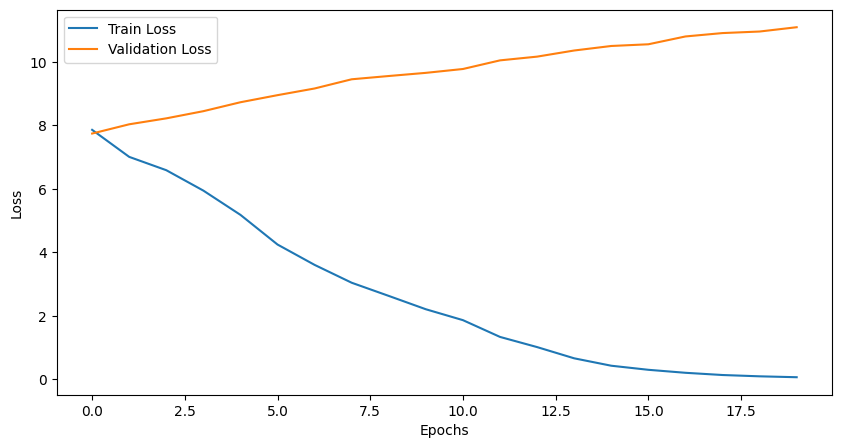

In [45]:
# Plot training results
plot_results(train_losses, val_losses)

In [46]:
# Save the model
torch.save(model.state_dict(), "seq2seq_model.pth")

In [47]:
# Evaluate BLEU score on test set
evaluate_bleu_score(model, test_loader, DEVICE, eng_vocab)

Sample Predictions and References:
Prediction: The gas bug of the race and the first person of the present and the first of money, of the Riga Peace the first of the Riga Peace the race
Reference: Lodin also said officials decided to cancel the runoff in order to save Afghans the expense and security risk of another election.
Prediction: As a result, the city of the and World to be the traditional to be the place of a "thorough and in the
Reference: Stone steps are laid along most of the path, and in the steeper sections steel cables provide a supporting handrail.
Prediction: No one of the University in the day that he was not possible that he will be issued by a new in the same way to launch a strong
Reference: Even traditionally, though, not all Sámi have been involved in big scale reindeer husbandry, but lived from fishing, hunting and similar, having reindeer mostly as draft animals.
Prediction: The case was also in the 2008 of the system and are also to see the of the love of the 

In [48]:
# Load the trained model
model.load_state_dict(torch.load("seq2seq_model.pth"))

<All keys matched successfully>

In [121]:
# Translate a sentence
sentence = "آپ کا نام کیا ہے"
translated_sentence = translate_sentence(sentence, model, urdu_vocab, eng_vocab, DEVICE)
print(f"Translated: {translated_sentence}")

Translated: The balance of an organization the US <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> customer's need. <eos> <eos> <eos> <eos> <eos> <eos> customer's need.
